# **DCGAN on celebA Dataset**

**Presented By:**

            Riya Shukla (22070126090)
            AIML-B1

In [2]:
import os

# Check all folders inside /kaggle/input
print("Datasets added to Kaggle environment:")
print(os.listdir('/kaggle/input'))

Datasets added to Kaggle environment:
['celeba-dataset']


In [3]:
import os

# Check the contents of /kaggle/input/celeba-dataset
dataset_path = '/kaggle/input/celeba-dataset'
print(f"Contents of {dataset_path}:")
print(os.listdir(dataset_path))


Contents of /kaggle/input/celeba-dataset:
['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']


In [4]:
import os

# Path to images folder
image_folder = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

# List the first 10 image file paths
image_files = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]

print(f"Found {len(image_files)} images.")
print("Sample image paths:")
for img in image_files[:10]:
    print(img)

Found 202599 images.
Sample image paths:
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/083648.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/168202.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/125778.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/059339.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/032501.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/160139.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/046754.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/178961.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/123482.jpg
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/039337.jpg


In [5]:
import os

# Correct path
image_folder = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

# List all images (assuming .jpg extension)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

print(f"Total images found: {len(image_files)}")

Total images found: 202599


In [6]:
celeba_path = '/kaggle/input/celeba-dataset'
if os.path.exists(celeba_path):
    print(f"CelebA dataset is added at: {celeba_path}")
else:
    print("CelebA dataset not found!")

CelebA dataset is added at: /kaggle/input/celeba-dataset


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [73]:
# Hyperparameters
IMAGE_SIZE = 64  # Standard for DCGAN
BATCH_SIZE = 128
LATENT_DIM = 100  # Size of the noise vector
NUM_CHANNELS = 3  # RGB images
NUM_EPOCHS = 8
LEARNING_RATE = 0.0002
BETA1 = 0.5  # Adam optimizer beta1

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path (update if needed)
DATA_PATH = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

In [75]:
def get_dataloader():
    #For Loading CelebA dataset with changes accordingly paper
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
    ])

    dataset = datasets.ImageFolder(root=os.path.dirname(DATA_PATH),
                                   transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)

    return dataloader

**Generator Network for DCGAN**

1. Uses ConvTranspose2d layers to upsample noise input
2. BatchNorm2d is applied after each convolution except the last.
3. Final activation is Tanh to output images in range [-1, 1]

In [76]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent vector (100) -> 1024 x 4 x 4 (features or channls with height width)
            nn.ConvTranspose2d(LATENT_DIM, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # 1024 -> 512 x 8 x 8
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 512 -> 256 x 16 x 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 256 -> 128 x 32 x 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 128 -> 3 x 64 x 64
            nn.ConvTranspose2d(128, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

**Forward pass of the Generator**

1. param input: Latent noise vector (batch_size, nz, 1, 1)
2. return: Generated image tensor (batch_size, nc, 64, 64)

**Discriminator Network for DCGAN**

1. Uses Conv2d layers to downsample input images
2. LeakyReLU activations for better gradient flow
3. Sigmoid activation to output probability of real/fake

**Initialize the Discriminator network**

1. param nc: Number of input image channels
2. parameter ndf: Number of discriminator filters in first layer

In [77]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # 3 x 64 x 64 -> 64 x 32 x 32
            nn.Conv2d(NUM_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 -> 128 x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 -> 256 x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 -> 512 x 4 x 4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 -> 1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Probability real/fake
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [78]:
def show_generated_images(epoch, images, num_images=16):
    
    grid = vutils.make_grid(images[:num_images], padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images - Epoch {epoch+1}")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

**Generate and save images during training**

1. generator: Trained generator model
2. param fixed_noise: Latent noise vector
3. param epoch: Current training epoch

In [79]:
def train_dcgan():
    dataloader = get_dataloader()

    netG = Generator().to(device)
    netD = Discriminator().to(device)

    criterion = nn.BCELoss()

    optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

    fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

    for epoch in range(NUM_EPOCHS):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # ===== Train Discriminator =====
            netD.zero_grad()
            output = netD(real_images)
            lossD_real = criterion(output, real_labels)

            noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
            fake_images = netG(noise)

            output = netD(fake_images.detach())
            lossD_fake = criterion(output, fake_labels)

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()

            # ===== Train Generator =====
            netG.zero_grad()
            output = netD(fake_images)
            lossG = criterion(output, real_labels)

            lossG.backward()
            optimizerG.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {i}/{len(dataloader)} Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

        # for generating  and show images after each epoch
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()

        show_generated_images(epoch, fake_images)

    print("Training complete!")


**Training function for DCGAN**

1. param dataloader: DataLoader for training dataset
2. param generator: Generator model
3. param discriminator: Discriminator model
4. param optimizerG: Optimizer for generator
5. param optimizerD: Optimizer for discriminator
6. param criterion: Loss function
7. param device: Training device (CPU/GPU)
8. param num_epochs: Number of training epochs

Epoch [1/8] Batch 0/1583 Loss D: 1.4500, Loss G: 2.1054
Epoch [1/8] Batch 100/1583 Loss D: 1.1932, Loss G: 2.0899
Epoch [1/8] Batch 200/1583 Loss D: 0.8172, Loss G: 2.4342
Epoch [1/8] Batch 300/1583 Loss D: 0.9840, Loss G: 3.2962
Epoch [1/8] Batch 400/1583 Loss D: 1.1359, Loss G: 1.2490
Epoch [1/8] Batch 500/1583 Loss D: 1.2942, Loss G: 2.4008
Epoch [1/8] Batch 600/1583 Loss D: 1.0158, Loss G: 1.3929
Epoch [1/8] Batch 700/1583 Loss D: 1.1484, Loss G: 2.0583
Epoch [1/8] Batch 800/1583 Loss D: 0.9294, Loss G: 2.1519
Epoch [1/8] Batch 900/1583 Loss D: 1.2994, Loss G: 2.7176
Epoch [1/8] Batch 1000/1583 Loss D: 0.9536, Loss G: 2.3340
Epoch [1/8] Batch 1100/1583 Loss D: 1.0778, Loss G: 1.2973
Epoch [1/8] Batch 1200/1583 Loss D: 0.9846, Loss G: 1.5757
Epoch [1/8] Batch 1300/1583 Loss D: 1.0150, Loss G: 1.5205
Epoch [1/8] Batch 1400/1583 Loss D: 0.9606, Loss G: 2.4854
Epoch [1/8] Batch 1500/1583 Loss D: 0.5217, Loss G: 2.8029


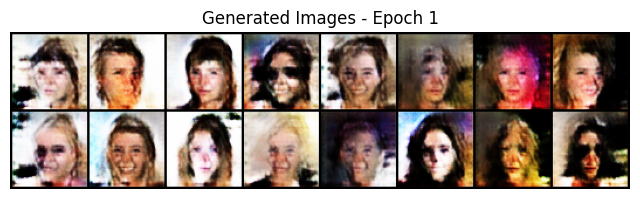

Epoch [2/8] Batch 0/1583 Loss D: 0.4938, Loss G: 2.8378
Epoch [2/8] Batch 100/1583 Loss D: 0.9526, Loss G: 1.3141
Epoch [2/8] Batch 200/1583 Loss D: 0.8614, Loss G: 1.5601
Epoch [2/8] Batch 300/1583 Loss D: 0.2393, Loss G: 2.4246
Epoch [2/8] Batch 400/1583 Loss D: 0.5213, Loss G: 3.0963
Epoch [2/8] Batch 500/1583 Loss D: 0.2265, Loss G: 3.0926
Epoch [2/8] Batch 600/1583 Loss D: 0.4127, Loss G: 3.3441
Epoch [2/8] Batch 700/1583 Loss D: 0.4005, Loss G: 2.7388
Epoch [2/8] Batch 800/1583 Loss D: 0.9020, Loss G: 4.1842
Epoch [2/8] Batch 900/1583 Loss D: 0.5300, Loss G: 2.7316
Epoch [2/8] Batch 1000/1583 Loss D: 0.2463, Loss G: 2.9568
Epoch [2/8] Batch 1100/1583 Loss D: 0.4414, Loss G: 2.3398
Epoch [2/8] Batch 1200/1583 Loss D: 0.2792, Loss G: 1.9190
Epoch [2/8] Batch 1300/1583 Loss D: 0.3450, Loss G: 2.3085
Epoch [2/8] Batch 1400/1583 Loss D: 0.3777, Loss G: 4.4794
Epoch [2/8] Batch 1500/1583 Loss D: 0.3176, Loss G: 3.7194


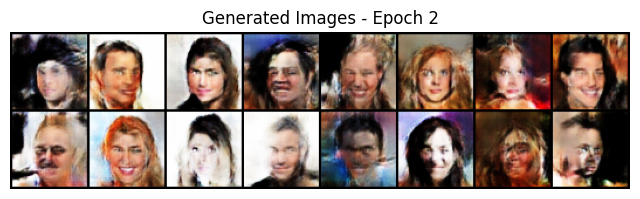

Epoch [3/8] Batch 0/1583 Loss D: 0.3486, Loss G: 2.9981
Epoch [3/8] Batch 100/1583 Loss D: 0.7097, Loss G: 3.7897
Epoch [3/8] Batch 200/1583 Loss D: 0.3933, Loss G: 5.1013
Epoch [3/8] Batch 300/1583 Loss D: 0.3228, Loss G: 2.8580
Epoch [3/8] Batch 400/1583 Loss D: 0.4328, Loss G: 3.5913
Epoch [3/8] Batch 500/1583 Loss D: 0.3723, Loss G: 3.4181
Epoch [3/8] Batch 600/1583 Loss D: 2.3353, Loss G: 0.2308
Epoch [3/8] Batch 700/1583 Loss D: 0.2488, Loss G: 3.4059
Epoch [3/8] Batch 800/1583 Loss D: 0.5641, Loss G: 2.3543
Epoch [3/8] Batch 900/1583 Loss D: 0.5904, Loss G: 1.7880
Epoch [3/8] Batch 1000/1583 Loss D: 0.5247, Loss G: 2.9375
Epoch [3/8] Batch 1100/1583 Loss D: 0.3112, Loss G: 2.1109
Epoch [3/8] Batch 1200/1583 Loss D: 0.4197, Loss G: 2.2770
Epoch [3/8] Batch 1300/1583 Loss D: 0.3548, Loss G: 2.7405
Epoch [3/8] Batch 1400/1583 Loss D: 0.5144, Loss G: 3.2837
Epoch [3/8] Batch 1500/1583 Loss D: 0.2667, Loss G: 2.7609


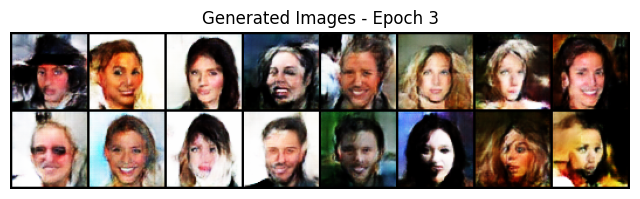

Epoch [4/8] Batch 0/1583 Loss D: 0.2886, Loss G: 4.1190
Epoch [4/8] Batch 100/1583 Loss D: 0.8593, Loss G: 5.1785
Epoch [4/8] Batch 200/1583 Loss D: 0.5578, Loss G: 2.8517
Epoch [4/8] Batch 300/1583 Loss D: 0.3055, Loss G: 4.3392
Epoch [4/8] Batch 400/1583 Loss D: 0.3736, Loss G: 3.8664
Epoch [4/8] Batch 500/1583 Loss D: 0.3684, Loss G: 2.6252
Epoch [4/8] Batch 600/1583 Loss D: 0.4751, Loss G: 2.8748
Epoch [4/8] Batch 700/1583 Loss D: 0.2359, Loss G: 4.4398
Epoch [4/8] Batch 800/1583 Loss D: 0.5873, Loss G: 2.1301
Epoch [4/8] Batch 900/1583 Loss D: 0.3442, Loss G: 2.6340
Epoch [4/8] Batch 1000/1583 Loss D: 0.2539, Loss G: 3.2969
Epoch [4/8] Batch 1100/1583 Loss D: 0.3824, Loss G: 2.9725
Epoch [4/8] Batch 1200/1583 Loss D: 0.2818, Loss G: 3.6886
Epoch [4/8] Batch 1300/1583 Loss D: 1.5856, Loss G: 0.7030
Epoch [4/8] Batch 1400/1583 Loss D: 0.3293, Loss G: 4.5384
Epoch [4/8] Batch 1500/1583 Loss D: 0.4210, Loss G: 3.2859


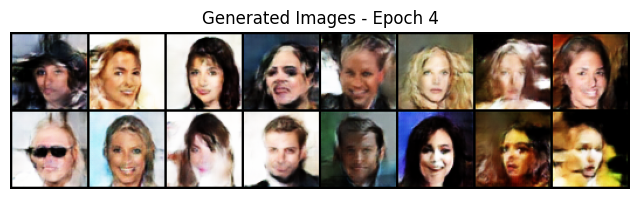

Epoch [5/8] Batch 0/1583 Loss D: 1.9424, Loss G: 0.1818
Epoch [5/8] Batch 100/1583 Loss D: 0.6864, Loss G: 1.6499
Epoch [5/8] Batch 200/1583 Loss D: 0.6121, Loss G: 4.9626
Epoch [5/8] Batch 300/1583 Loss D: 0.3291, Loss G: 4.0293
Epoch [5/8] Batch 400/1583 Loss D: 0.4397, Loss G: 3.3428
Epoch [5/8] Batch 500/1583 Loss D: 0.8349, Loss G: 3.8421
Epoch [5/8] Batch 600/1583 Loss D: 0.3542, Loss G: 1.9263
Epoch [5/8] Batch 700/1583 Loss D: 1.5864, Loss G: 5.5746
Epoch [5/8] Batch 800/1583 Loss D: 1.2531, Loss G: 6.2699
Epoch [5/8] Batch 900/1583 Loss D: 0.3161, Loss G: 2.4194
Epoch [5/8] Batch 1000/1583 Loss D: 0.6498, Loss G: 5.9275
Epoch [5/8] Batch 1100/1583 Loss D: 0.3182, Loss G: 4.0731
Epoch [5/8] Batch 1200/1583 Loss D: 0.3283, Loss G: 2.7146
Epoch [5/8] Batch 1300/1583 Loss D: 1.1068, Loss G: 7.3459
Epoch [5/8] Batch 1400/1583 Loss D: 0.2319, Loss G: 3.2951
Epoch [5/8] Batch 1500/1583 Loss D: 0.8273, Loss G: 1.0296


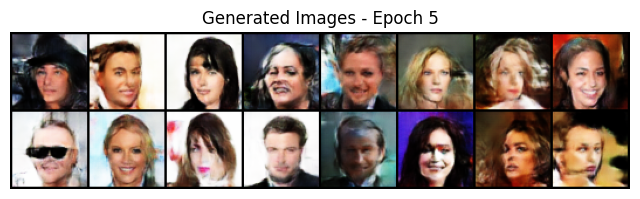

Epoch [6/8] Batch 0/1583 Loss D: 0.6296, Loss G: 2.5961
Epoch [6/8] Batch 100/1583 Loss D: 0.6672, Loss G: 5.5558
Epoch [6/8] Batch 200/1583 Loss D: 0.4473, Loss G: 2.3873
Epoch [6/8] Batch 300/1583 Loss D: 0.3733, Loss G: 3.6303
Epoch [6/8] Batch 400/1583 Loss D: 0.2279, Loss G: 3.9062
Epoch [6/8] Batch 500/1583 Loss D: 0.3487, Loss G: 3.3219
Epoch [6/8] Batch 600/1583 Loss D: 0.3139, Loss G: 4.5753
Epoch [6/8] Batch 700/1583 Loss D: 0.3515, Loss G: 4.5862
Epoch [6/8] Batch 800/1583 Loss D: 0.3163, Loss G: 3.6848
Epoch [6/8] Batch 900/1583 Loss D: 0.7494, Loss G: 3.8408
Epoch [6/8] Batch 1000/1583 Loss D: 0.5595, Loss G: 1.5789
Epoch [6/8] Batch 1100/1583 Loss D: 0.6255, Loss G: 1.7738
Epoch [6/8] Batch 1200/1583 Loss D: 0.4487, Loss G: 1.4233
Epoch [6/8] Batch 1300/1583 Loss D: 0.0786, Loss G: 4.6323
Epoch [6/8] Batch 1400/1583 Loss D: 0.5627, Loss G: 3.2728
Epoch [6/8] Batch 1500/1583 Loss D: 0.2855, Loss G: 2.9193


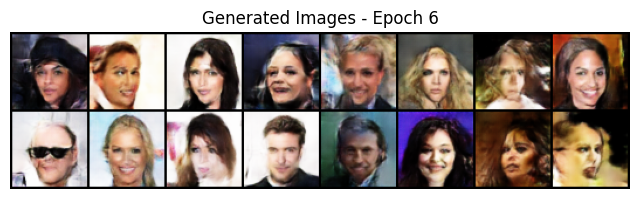

Epoch [7/8] Batch 0/1583 Loss D: 0.6100, Loss G: 5.2170
Epoch [7/8] Batch 100/1583 Loss D: 0.4219, Loss G: 1.9381
Epoch [7/8] Batch 200/1583 Loss D: 0.2464, Loss G: 3.0400
Epoch [7/8] Batch 300/1583 Loss D: 0.2296, Loss G: 3.7623
Epoch [7/8] Batch 400/1583 Loss D: 0.3327, Loss G: 2.8601
Epoch [7/8] Batch 500/1583 Loss D: 0.2346, Loss G: 2.6745
Epoch [7/8] Batch 600/1583 Loss D: 0.5061, Loss G: 4.0704
Epoch [7/8] Batch 700/1583 Loss D: 0.3623, Loss G: 4.1570
Epoch [7/8] Batch 800/1583 Loss D: 0.5240, Loss G: 2.8131
Epoch [7/8] Batch 900/1583 Loss D: 0.3745, Loss G: 1.7515
Epoch [7/8] Batch 1000/1583 Loss D: 0.4203, Loss G: 1.5252
Epoch [7/8] Batch 1100/1583 Loss D: 0.3004, Loss G: 2.0210
Epoch [7/8] Batch 1200/1583 Loss D: 0.2571, Loss G: 3.8670
Epoch [7/8] Batch 1300/1583 Loss D: 0.8307, Loss G: 1.1574
Epoch [7/8] Batch 1400/1583 Loss D: 0.1751, Loss G: 3.7408
Epoch [7/8] Batch 1500/1583 Loss D: 0.4381, Loss G: 6.2715


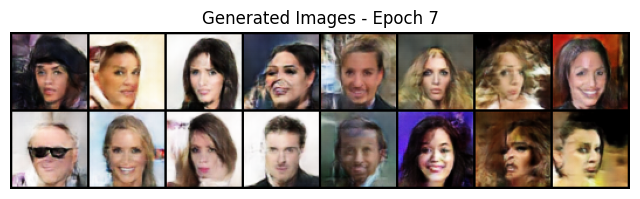

Epoch [8/8] Batch 0/1583 Loss D: 0.5613, Loss G: 5.7073
Epoch [8/8] Batch 100/1583 Loss D: 0.4807, Loss G: 4.0243
Epoch [8/8] Batch 200/1583 Loss D: 0.2140, Loss G: 2.9010
Epoch [8/8] Batch 300/1583 Loss D: 0.3610, Loss G: 3.9255
Epoch [8/8] Batch 400/1583 Loss D: 0.1833, Loss G: 3.9173
Epoch [8/8] Batch 500/1583 Loss D: 0.2348, Loss G: 4.0414
Epoch [8/8] Batch 600/1583 Loss D: 0.1903, Loss G: 3.7174
Epoch [8/8] Batch 700/1583 Loss D: 0.3253, Loss G: 2.0748
Epoch [8/8] Batch 800/1583 Loss D: 0.3444, Loss G: 3.6775
Epoch [8/8] Batch 900/1583 Loss D: 0.0056, Loss G: 7.8762
Epoch [8/8] Batch 1000/1583 Loss D: 0.0001, Loss G: 51.2511
Epoch [8/8] Batch 1100/1583 Loss D: 0.0001, Loss G: 50.9315
Epoch [8/8] Batch 1200/1583 Loss D: 0.0000, Loss G: 50.7455
Epoch [8/8] Batch 1300/1583 Loss D: 0.0000, Loss G: 50.7117
Epoch [8/8] Batch 1400/1583 Loss D: 0.0000, Loss G: 50.6439
Epoch [8/8] Batch 1500/1583 Loss D: 0.0000, Loss G: 50.8394


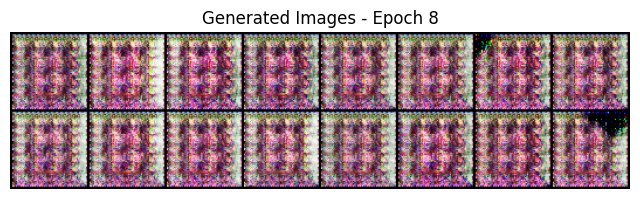

Training complete!


In [80]:
if __name__ == "__main__":
    train_dcgan()